In [1]:
import base64
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import shutil
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

# Custom imports
from graph_nns import GraphNNA3C, SmallFullyConnectedGNNLayer, FullyConnectedGNNLayer
import vectorized_env
from vectorized_env import KaggleMABEnvTorchVectorized
import vectorized_agents as va

%matplotlib inline
jtplot.style()

DEVICE = torch.device('cuda')
OBS_NORM = 100. / 1999.

## A3C RL algorithm

In [2]:
def wrap_model(model):
    def model_wrapped(states):
        return model.sample_action(states.unsqueeze(0)).squeeze(0)
    return model_wrapped


class A3CVectorized():
    def __init__(self, model_constructor, optimizer, model=None, device=torch.device('cuda'), exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP'),
                 play_against_past_selves=True, n_past_selves=8, checkpoint_freq=10, initial_opponent_pool=[], opp_posterior_decay=0.95):
        self.model_constructor = model_constructor
        self.optimizer = optimizer
        if model is None:
            self.model = self.model_constructor()
        else:
            self.model = model
        self.device = device
        self.exp_folder = exp_folder
        if str(self.exp_folder) == '/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP':
            print('WARNING: Using TEMP exp_folder')
            shutil.rmtree(self.exp_folder)
        elif self.exp_folder.exists():
            raise RuntimeError(f'Experiment folder {self.exp_folder} already exists')
        else:
            print(f'Saving results to {self.exp_folder}')
        self.exp_folder.mkdir(exist_ok=True)
        self.play_against_past_selves = play_against_past_selves
        self.n_past_selves = n_past_selves
        self.checkpoint_freq = checkpoint_freq
        self.initial_opponent_pool = initial_opponent_pool
        self.opp_posterior_decay = opp_posterior_decay
        
        self.env = None
        self.opp_a = np.ones(len(self.initial_opponent_pool))
        self.opp_b = np.ones(len(self.initial_opponent_pool))
        self.checkpoints = []
        self.true_ep_num = 0
        
    def train(self, n_episodes, batch_size=30, gamma=0.9, **env_kwargs):
        if self.play_against_past_selves and 'opponent' in env_kwargs.keys():
            raise RuntimeError('Cannot play against past selves when opponent is defined')
        self.env = None
        self.model.train()
        episode_reward_sums = []
        
        for ep_num in tqdm.trange(n_episodes):
            if self.play_against_past_selves:
                opponents, opponent_idxs = self.sample_opponents()
                self.env = KaggleMABEnvTorchVectorized(opponent=opponents, **env_kwargs)
            else:
                self.env = KaggleMABEnvTorchVectorized(**env_kwargs)
            buffer_s, buffer_a, buffer_r = [], [], []
            s, r, _, _ = self.env.reset()
            episode_reward_sums.append(r)
            step_count = 1
            while not self.env.done:
                # Batch size of 1 for inference
                a = self.model.sample_action(s.to(device=self.device).unsqueeze(0)).squeeze(0)
                next_s, r, done, _ = self.env.step(a)

                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)

                if step_count % batch_size == 0 or done:
                    if done:
                        v_next_s = torch.zeros_like(buffer_r[-1])
                    else:
                        _, v_next_s = self.model(next_s.to(device=self.device).unsqueeze(0))
                        v_next_s = v_next_s.detach().squeeze(0)
                    v_next_s.to(device=self.device)

                    buffer_v_target = []
                    for r in buffer_r[::-1]:
                        v_next_s = r + gamma * v_next_s
                        buffer_v_target.append(v_next_s)
                    buffer_v_target.reverse()

                    loss = self.model.loss_func(
                        torch.stack(buffer_s).to(device=self.device),
                        torch.stack(buffer_a).to(device=self.device),
                        torch.stack(buffer_v_target).to(device=self.device)
                    )
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    buffer_s, buffer_a, buffer_r = [], [], []
                s = next_s
                episode_reward_sums[-1] += r
                step_count += 1
            if self.play_against_past_selves:
                if opponent_idxs is not None:
                    self.update_opponent_scores(opponent_idxs, self.env.player_rewards_sums.cpu())
                if ep_num % self.checkpoint_freq == 0:
                    self.checkpoint()
            if ep_num % self.checkpoint_freq == 0:
                self.save()
            episode_reward_sums[-1] = episode_reward_sums[-1].mean() / self.env.r_norm
            self.true_ep_num += 1
        self.save(finished=True)
        return episode_reward_sums
    
    def sample_opponents(self):
        if len(self.initial_opponent_pool) + len(self.checkpoints) == 0:
            print('No opponents sampled')
            return None, None
        else:
            opponents = []
            opponent_idxs = []
            for i in range(self.n_past_selves):
                # Sample opponents randomly if the agent is losing > some fraction of it's games, otherwise use thompson sampling
                if np.sum(self.opp_b - 1) <= np.sum(self.opp_a - 1) / 5.:
                    if i == 0:
                        print('Sampling opponents randomly')
                    selected_opp_idx = np.random.randint(len(self.opp_a))
                else:
                    if i == 0:
                        print('Sampling opponents using Thompson sampling')
                    selected_opp_idx = np.random.beta(self.opp_a, self.opp_b).argmax()
                opponent_idxs.append(selected_opp_idx)
                opponents.append(self.get_opponent(selected_opp_idx))
                if selected_opp_idx < len(self.initial_opponent_pool):
                    try:
                        print(f'Opponent {i}: {opponents[-1].name} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                    except AttributeError:
                        print(f'Opponent {i}: {opponents[-1]} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                else:
                    print(f'Opponent {i}: Checkpoint #{selected_opp_idx - len(self.initial_opponent_pool)} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
            print()
            return va.MultiAgent(opponents), opponent_idxs

    def update_opponent_scores(self, curr_opp_idxs, player_rewards_sums):
        # player_rewards_sums.shape is (n_envs, n_players, n_bandits)
        # Decay posteriors
        self.opp_a = np.maximum(self.opp_a * self.opp_posterior_decay, 1.)
        self.opp_b = np.maximum(self.opp_b * self.opp_posterior_decay, 1.)
        
        # Update posteriors with new w/l stats
        global game_scores, rewards_sums
        rewards_sums = player_rewards_sums.sum(dim=2)
        game_scores = torch.zeros(rewards_sums.shape)
        winners_idxs = rewards_sums.argmax(dim=1)
        draws_mask = rewards_sums[:,0] == rewards_sums[:,1]
        game_scores[torch.arange(game_scores.shape[0]), winners_idxs] = 1.
        game_scores[draws_mask] = 0.5
        game_scores = [gs.numpy() for gs in game_scores.chunk(self.n_past_selves)]
        for match_idx, opp_idx in enumerate(curr_opp_idxs):
            self.opp_a[opp_idx] += game_scores[match_idx][:,1].sum()
            self.opp_b[opp_idx] += game_scores[match_idx][:,0].sum()
            
    def checkpoint(self):
        self.model.cpu()
        self.checkpoints.append(self.model.state_dict())
        self.opp_a = np.append(self.opp_a, 1.)
        self.opp_b = np.append(self.opp_b, 1.)
        self.model.to(device=self.device)
    
    def save(self, finished=False):
        if finished:
            file_path_base = self.exp_folder / 'final'
        else:
            file_path_base = self.exp_folder / str(self.true_ep_num)
        # Save model params
        self.model.cpu()
        state_dict_bytes = pickle.dumps({
            'model_state_dict': self.model.state_dict(),
        })
        serialized_string = base64.b64encode(state_dict_bytes)
        with open(f'{file_path_base}_cp.txt', 'w') as f:
            f.write(str(serialized_string))
        self.model.to(device=self.device)
        # Save skill estimates
        if self.play_against_past_selves:
            checkpoint_idxs = np.arange(len(a3c_alg.opp_a)) - len(a3c_alg.initial_opponent_pool)
            checkpoint_idxs = np.where(
                checkpoint_idxs < 0,
                np.nan,
                checkpoint_idxs
            )
            df = pd.DataFrame({
                'opp_a': a3c_alg.opp_a,
                'opp_b': a3c_alg.opp_b,
                'est_opp_skill': a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b),
                'checkpoint_idxs': checkpoint_idxs
            })
            df.to_csv(f'{file_path_base}_skill_estimates.csv')
    
    def get_opponent(self, idx):
        if idx < 0:
            raise IndexError(f'Negative indexing is not supported')
        elif idx < len(self.initial_opponent_pool):
            return self.initial_opponent_pool[idx]
        elif idx < len(self.initial_opponent_pool) + len(self.checkpoints):
            checkpoint_idx = idx - len(self.initial_opponent_pool)
            checkpoint_opp = self.model_constructor()
            checkpoint_opp.load_state_dict(self.checkpoints[checkpoint_idx])
            checkpoint_opp.to(device=self.device)
            checkpoint_opp.eval()
            return wrap_model(checkpoint_opp)
        else:
            raise IndexError(f'Index {idx} is out of bounds')

## Optional: load a saved model state_dict from a serialized string file

In [3]:
#with open('rl_agents/ss_temp.txt', 'r') as f:
with open('runs/Small_GNN_v3/final_cp.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)

## RL training
#### TODO:
Change GNN layer option to "efficient_GNN"

Implement "fictitious self-play" to improve trained model robustness. On a related note, maybe compare trained agents against many/all agents from this notebook: https://www.kaggle.com/jamesmcguigan/santa-2020-agents-comparison

Implement new RL algorithm - AWAC, and use top team's logs as training data. See: https://www.kaggle.com/masatomatsui/santa-episode-scraper

Eventually, experiment with reward_type = END_OF_GAME

In [4]:
graph_nn_kwargs = dict(
    in_features=3,
    n_nodes=100,
    n_hidden_layers=10,
    layer_sizes=24,
    #layer_class=FullyConnectedGNNLayer,
    layer_class=SmallFullyConnectedGNNLayer,
    skip_connection_n=1
)
model = GraphNNA3C(**graph_nn_kwargs)
try:
    sd = loaded_state_dicts['model_state_dict']
    model.load_state_dict(sd)
    print('Successfully loaded saved model')
    del loaded_state_dicts
except NameError:
    pass
model.to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

env_kwargs = dict(
    n_envs=512,
    out_device=DEVICE,
    reward_type=vectorized_env.EVERY_STEP_EV
)
rl_alg_kwargs = dict(
    batch_size=30,
    gamma=0.99
)

# Used for va.run_vectorized_vs
def model_wrapped(states):
    return model.sample_action(states.unsqueeze(0)).squeeze(0)

def model_constructor():
    return GraphNNA3C(**graph_nn_kwargs)

# initial_opponent_pool = []
initial_opponent_pool = [
    #va.BasicThompsonSampling(OBS_NORM),
    va.PullVegasSlotMachines(OBS_NORM),
    #va.SavedRLAgent('a3c_agent_v0'),
    va.SavedRLAgent('a3c_agent_v1'),
    #va.SavedRLAgent('a3c_agent_v2'),
    va.SavedRLAgent('a3c_agent_v3'),
]

a3c_alg = A3CVectorized(model_constructor, optimizer, model=model, device=DEVICE,
                        exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/Small_GNN_v3_contd'),
                        play_against_past_selves=True,
                        n_past_selves=4,
                        checkpoint_freq=10,
                        initial_opponent_pool=initial_opponent_pool,
                        opp_posterior_decay=0.95)

Successfully loaded saved model
Saving results to /home/isaiah/GitHub/Kaggle/Santa_2020/runs/Small_GNN_v3_contd


  0%|          | 0/5 [00:00<?, ?it/s]

Sampling opponents randomly
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1.00 and beta 1.00
Opponent 1: PullVegasSlotMachines with alpha 1.00 and beta 1.00
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1.00 and beta 1.00
Opponent 3: PullVegasSlotMachines with alpha 1.00 and beta 1.00



 20%|██        | 1/5 [00:19<01:16, 19.19s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 84.00 and beta 46.00
Opponent 1: Checkpoint #0 with alpha 1.00 and beta 1.00
Opponent 2: SavedRLAgent: a3c_agent_v1 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #0 with alpha 1.00 and beta 1.00



 40%|████      | 2/5 [00:43<01:02, 20.81s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 123.30 and beta 64.20
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 123.30 and beta 64.20
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 123.30 and beta 64.20
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 123.30 and beta 64.20



 60%|██████    | 3/5 [01:06<00:43, 21.50s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 280.13 and beta 153.99
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 280.13 and beta 153.99
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 280.13 and beta 153.99
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 280.13 and beta 153.99



 80%|████████  | 4/5 [01:29<00:21, 21.89s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 443.63 and beta 224.79
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 443.63 and beta 224.79
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 443.63 and beta 224.79
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 443.63 and beta 224.79



100%|██████████| 5/5 [01:53<00:00, 22.64s/it]


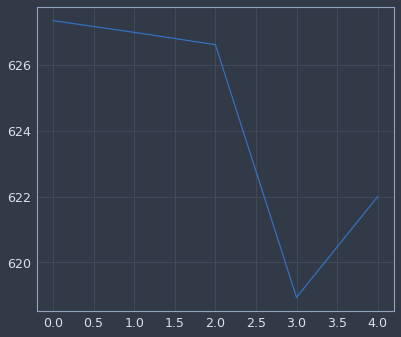

In [5]:
env_kwargs['n_envs'] = 256
episode_reward_sums = a3c_alg.train(n_episodes=5, **rl_alg_kwargs, **env_kwargs)

#episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=50, **rl_alg_kwargs)
plt.plot(episode_reward_sums)
plt.show();
#plt.plot(episode_reward_sums);

  0%|          | 0/70 [00:00<?, ?it/s]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2052.01 and beta 345.97
Opponent 1: Checkpoint #2 with alpha 2052.01 and beta 345.97
Opponent 2: Checkpoint #2 with alpha 2052.01 and beta 345.97
Opponent 3: Checkpoint #2 with alpha 2052.01 and beta 345.97



  1%|▏         | 1/70 [00:27<31:43, 27.58s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2140.41 and beta 393.67
Opponent 1: Checkpoint #2 with alpha 2140.41 and beta 393.67
Opponent 2: Checkpoint #2 with alpha 2140.41 and beta 393.67
Opponent 3: Checkpoint #2 with alpha 2140.41 and beta 393.67



  3%|▎         | 2/70 [00:54<31:05, 27.43s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2265.89 and beta 397.49
Opponent 1: Checkpoint #2 with alpha 2265.89 and beta 397.49
Opponent 2: Checkpoint #4 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #2 with alpha 2265.89 and beta 397.49



  4%|▍         | 3/70 [01:21<30:21, 27.18s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2304.60 and beta 417.61
Opponent 1: Checkpoint #2 with alpha 2304.60 and beta 417.61
Opponent 2: Checkpoint #2 with alpha 2304.60 and beta 417.61
Opponent 3: Checkpoint #2 with alpha 2304.60 and beta 417.61



  6%|▌         | 4/70 [01:48<29:49, 27.11s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2367.87 and beta 474.23
Opponent 1: Checkpoint #2 with alpha 2367.87 and beta 474.23
Opponent 2: Checkpoint #2 with alpha 2367.87 and beta 474.23
Opponent 3: Checkpoint #2 with alpha 2367.87 and beta 474.23



  7%|▋         | 5/70 [02:14<29:14, 27.00s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2428.97 and beta 527.02
Opponent 1: Checkpoint #2 with alpha 2428.97 and beta 527.02
Opponent 2: Checkpoint #2 with alpha 2428.97 and beta 527.02
Opponent 3: Checkpoint #2 with alpha 2428.97 and beta 527.02



  9%|▊         | 6/70 [02:41<28:40, 26.88s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2457.52 and beta 606.67
Opponent 1: Checkpoint #2 with alpha 2457.52 and beta 606.67
Opponent 2: Checkpoint #2 with alpha 2457.52 and beta 606.67
Opponent 3: Checkpoint #2 with alpha 2457.52 and beta 606.67



 10%|█         | 7/70 [03:08<28:09, 26.82s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2551.15 and beta 615.84
Opponent 1: Checkpoint #2 with alpha 2551.15 and beta 615.84
Opponent 2: Checkpoint #2 with alpha 2551.15 and beta 615.84
Opponent 3: Checkpoint #2 with alpha 2551.15 and beta 615.84



 11%|█▏        | 8/70 [03:35<27:43, 26.83s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2607.59 and beta 657.04
Opponent 1: Checkpoint #2 with alpha 2607.59 and beta 657.04
Opponent 2: Checkpoint #2 with alpha 2607.59 and beta 657.04
Opponent 3: Checkpoint #2 with alpha 2607.59 and beta 657.04



 13%|█▎        | 9/70 [04:02<27:22, 26.93s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2662.71 and beta 694.69
Opponent 1: Checkpoint #2 with alpha 2662.71 and beta 694.69
Opponent 2: Checkpoint #2 with alpha 2662.71 and beta 694.69
Opponent 3: Checkpoint #2 with alpha 2662.71 and beta 694.69



 14%|█▍        | 10/70 [04:29<26:53, 26.89s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2721.58 and beta 723.96
Opponent 1: Checkpoint #2 with alpha 2721.58 and beta 723.96
Opponent 2: Checkpoint #2 with alpha 2721.58 and beta 723.96
Opponent 3: Checkpoint #2 with alpha 2721.58 and beta 723.96



 16%|█▌        | 11/70 [04:55<26:24, 26.86s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2771.00 and beta 758.26
Opponent 1: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #2 with alpha 2771.00 and beta 758.26



 17%|█▋        | 12/70 [05:22<25:56, 26.84s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2726.95 and beta 753.85
Opponent 1: Checkpoint #2 with alpha 2726.95 and beta 753.85
Opponent 2: Checkpoint #2 with alpha 2726.95 and beta 753.85
Opponent 3: Checkpoint #2 with alpha 2726.95 and beta 753.85



 19%|█▊        | 13/70 [05:49<25:24, 26.75s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2770.60 and beta 792.15
Opponent 1: Checkpoint #2 with alpha 2770.60 and beta 792.15
Opponent 2: Checkpoint #2 with alpha 2770.60 and beta 792.15
Opponent 3: Checkpoint #2 with alpha 2770.60 and beta 792.15



 20%|██        | 14/70 [06:16<25:00, 26.79s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2802.07 and beta 838.55
Opponent 1: Checkpoint #2 with alpha 2802.07 and beta 838.55
Opponent 2: Checkpoint #2 with alpha 2802.07 and beta 838.55
Opponent 3: Checkpoint #2 with alpha 2802.07 and beta 838.55



 21%|██▏       | 15/70 [06:42<24:36, 26.84s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2831.47 and beta 883.12
Opponent 1: Checkpoint #2 with alpha 2831.47 and beta 883.12
Opponent 2: Checkpoint #2 with alpha 2831.47 and beta 883.12
Opponent 3: Checkpoint #0 with alpha 6.50 and beta 7.82



 23%|██▎       | 16/70 [07:09<24:11, 26.88s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2810.39 and beta 910.46
Opponent 1: Checkpoint #2 with alpha 2810.39 and beta 910.46
Opponent 2: Checkpoint #2 with alpha 2810.39 and beta 910.46
Opponent 3: Checkpoint #2 with alpha 2810.39 and beta 910.46



 24%|██▍       | 17/70 [07:36<23:46, 26.92s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2808.87 and beta 981.94
Opponent 1: Checkpoint #2 with alpha 2808.87 and beta 981.94
Opponent 2: Checkpoint #2 with alpha 2808.87 and beta 981.94
Opponent 3: Checkpoint #2 with alpha 2808.87 and beta 981.94



 26%|██▌       | 18/70 [08:04<23:24, 27.00s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v1 with alpha 36.87 and beta 21.74
Opponent 1: Checkpoint #2 with alpha 2802.93 and beta 1054.34
Opponent 2: Checkpoint #2 with alpha 2802.93 and beta 1054.34
Opponent 3: Checkpoint #2 with alpha 2802.93 and beta 1054.34



 27%|██▋       | 19/70 [08:29<22:31, 26.51s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2745.28 and beta 1111.13
Opponent 1: Checkpoint #2 with alpha 2745.28 and beta 1111.13
Opponent 2: Checkpoint #2 with alpha 2745.28 and beta 1111.13
Opponent 3: Checkpoint #2 with alpha 2745.28 and beta 1111.13



 29%|██▊       | 20/70 [08:56<22:09, 26.60s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2726.02 and beta 1193.57
Opponent 1: Checkpoint #2 with alpha 2726.02 and beta 1193.57
Opponent 2: Checkpoint #3 with alpha 9.84 and beta 10.45
Opponent 3: Checkpoint #2 with alpha 2726.02 and beta 1193.57



 30%|███       | 21/70 [09:23<21:51, 26.77s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #6 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #6 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #2 with alpha 2678.22 and beta 1237.39



 31%|███▏      | 22/70 [09:50<21:25, 26.78s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2585.81 and beta 1198.02
Opponent 1: Checkpoint #2 with alpha 2585.81 and beta 1198.02
Opponent 2: Checkpoint #2 with alpha 2585.81 and beta 1198.02
Opponent 3: Checkpoint #2 with alpha 2585.81 and beta 1198.02



 33%|███▎      | 23/70 [10:17<20:59, 26.79s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2593.52 and beta 1257.12
Opponent 1: Checkpoint #2 with alpha 2593.52 and beta 1257.12
Opponent 2: Checkpoint #2 with alpha 2593.52 and beta 1257.12
Opponent 3: Checkpoint #0 with alpha 32.25 and beta 21.95



 34%|███▍      | 24/70 [10:43<20:28, 26.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2568.34 and beta 1281.76
Opponent 1: Checkpoint #2 with alpha 2568.34 and beta 1281.76
Opponent 2: Checkpoint #2 with alpha 2568.34 and beta 1281.76
Opponent 3: Checkpoint #2 with alpha 2568.34 and beta 1281.76



 36%|███▌      | 25/70 [11:08<19:42, 26.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2575.92 and beta 1337.68
Opponent 1: SavedRLAgent: a3c_agent_v1 with alpha 51.84 and beta 36.13
Opponent 2: Checkpoint #2 with alpha 2575.92 and beta 1337.68
Opponent 3: SavedRLAgent: a3c_agent_v1 with alpha 51.84 and beta 36.13



 37%|███▋      | 26/70 [11:31<18:26, 25.14s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2526.63 and beta 1319.29
Opponent 1: Checkpoint #2 with alpha 2526.63 and beta 1319.29
Opponent 2: Checkpoint #2 with alpha 2526.63 and beta 1319.29
Opponent 3: Checkpoint #2 with alpha 2526.63 and beta 1319.29



 39%|███▊      | 27/70 [11:56<17:58, 25.09s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2557.30 and beta 1352.33
Opponent 1: PullVegasSlotMachines with alpha 2.88 and beta 4.47
Opponent 2: Checkpoint #2 with alpha 2557.30 and beta 1352.33
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 198.38 and beta 128.12



 40%|████      | 28/70 [12:17<16:46, 23.96s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2502.93 and beta 1339.21
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 233.47 and beta 140.72
Opponent 2: Checkpoint #2 with alpha 2502.93 and beta 1339.21
Opponent 3: Checkpoint #2 with alpha 2502.93 and beta 1339.21



 41%|████▏     | 29/70 [12:41<16:23, 23.99s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #4 with alpha 5.01 and beta 12.39
Opponent 1: Checkpoint #2 with alpha 2478.28 and beta 1363.75
Opponent 2: Checkpoint #2 with alpha 2478.28 and beta 1363.75
Opponent 3: Checkpoint #2 with alpha 2478.28 and beta 1363.75



 43%|████▎     | 30/70 [13:06<16:10, 24.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2486.37 and beta 1355.56
Opponent 1: Checkpoint #2 with alpha 2486.37 and beta 1355.56
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 244.90 and beta 153.60
Opponent 3: Checkpoint #2 with alpha 2486.37 and beta 1355.56



 44%|████▍     | 31/70 [13:30<15:43, 24.19s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2518.05 and beta 1323.79
Opponent 1: Checkpoint #2 with alpha 2518.05 and beta 1323.79
Opponent 2: Checkpoint #1 with alpha 4.79 and beta 7.36
Opponent 3: Checkpoint #7 with alpha 1.00 and beta 1.00



 46%|████▌     | 32/70 [13:55<15:28, 24.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 57.55 and beta 18.00
Opponent 1: Checkpoint #1 with alpha 57.55 and beta 18.00
Opponent 2: Checkpoint #1 with alpha 57.55 and beta 18.00
Opponent 3: Checkpoint #1 with alpha 57.55 and beta 18.00



 47%|████▋     | 33/70 [14:20<15:10, 24.60s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 243.68 and beta 84.10
Opponent 1: Checkpoint #1 with alpha 243.68 and beta 84.10
Opponent 2: Checkpoint #1 with alpha 243.68 and beta 84.10
Opponent 3: Checkpoint #1 with alpha 243.68 and beta 84.10



 49%|████▊     | 34/70 [14:45<14:49, 24.72s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 381.49 and beta 185.89
Opponent 1: Checkpoint #1 with alpha 381.49 and beta 185.89
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 242.77 and beta 136.68
Opponent 3: Checkpoint #1 with alpha 381.49 and beta 185.89



 50%|█████     | 35/70 [15:09<14:18, 24.52s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2136.28 and beta 1102.67
Opponent 1: Checkpoint #7 with alpha 35.58 and beta 21.01
Opponent 2: Checkpoint #7 with alpha 35.58 and beta 21.01
Opponent 3: Checkpoint #7 with alpha 35.58 and beta 21.01



 51%|█████▏    | 36/70 [15:34<13:59, 24.69s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2065.96 and beta 1075.03
Opponent 1: Checkpoint #1 with alpha 446.42 and beta 248.04
Opponent 2: Checkpoint #2 with alpha 2065.96 and beta 1075.03
Opponent 3: Checkpoint #2 with alpha 2065.96 and beta 1075.03



 53%|█████▎    | 37/70 [15:59<13:37, 24.79s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 244.70 and beta 138.39
Opponent 1: Checkpoint #2 with alpha 2060.67 and beta 1115.28
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 244.70 and beta 138.39
Opponent 3: Checkpoint #2 with alpha 2060.67 and beta 1115.28



 54%|█████▍    | 38/70 [16:22<12:57, 24.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2032.13 and beta 1113.02
Opponent 1: Checkpoint #2 with alpha 2032.13 and beta 1113.02
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 313.96 and beta 177.97
Opponent 3: Checkpoint #0 with alpha 29.33 and beta 26.99



 56%|█████▌    | 39/70 [16:47<12:30, 24.22s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2007.03 and beta 1108.87
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 339.76 and beta 191.58
Opponent 2: Checkpoint #2 with alpha 2007.03 and beta 1108.87
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 339.76 and beta 191.58



 57%|█████▋    | 40/70 [17:10<11:57, 23.92s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 389.76 and beta 230.75
Opponent 1: Checkpoint #2 with alpha 1986.17 and beta 1101.92
Opponent 2: SavedRLAgent: a3c_agent_v1 with alpha 60.59 and beta 42.59
Opponent 3: Checkpoint #2 with alpha 1986.17 and beta 1101.92



 59%|█████▊    | 41/70 [17:34<11:33, 23.90s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1960.37 and beta 1101.33
Opponent 1: Checkpoint #2 with alpha 1960.37 and beta 1101.33
Opponent 2: Checkpoint #2 with alpha 1960.37 and beta 1101.33
Opponent 3: Checkpoint #2 with alpha 1960.37 and beta 1101.33



 60%|██████    | 42/70 [17:59<11:20, 24.31s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #8 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #8 with alpha 1.00 and beta 1.00
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 362.15 and beta 208.93
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 362.15 and beta 208.93



 61%|██████▏   | 43/70 [18:22<10:50, 24.08s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1914.58 and beta 1091.80
Opponent 1: Checkpoint #2 with alpha 1914.58 and beta 1091.80
Opponent 2: Checkpoint #2 with alpha 1914.58 and beta 1091.80
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 423.54 and beta 246.98



 63%|██████▎   | 44/70 [18:47<10:28, 24.19s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1923.85 and beta 1124.21
Opponent 1: Checkpoint #6 with alpha 32.84 and beta 29.93
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 442.87 and beta 258.13
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 442.87 and beta 258.13



 64%|██████▍   | 45/70 [19:10<09:57, 23.91s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1856.66 and beta 1103.00
Opponent 1: Checkpoint #1 with alpha 326.84 and beta 205.43
Opponent 2: Checkpoint #2 with alpha 1856.66 and beta 1103.00
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 499.72 and beta 294.22



 66%|██████▌   | 46/70 [19:34<09:34, 23.94s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #8 with alpha 64.73 and beta 46.73
Opponent 1: Checkpoint #8 with alpha 64.73 and beta 46.73
Opponent 2: Checkpoint #5 with alpha 10.49 and beta 12.24
Opponent 3: Checkpoint #2 with alpha 1827.83 and beta 1111.85



 67%|██████▋   | 47/70 [19:59<09:17, 24.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 486.15 and beta 291.19
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 486.15 and beta 291.19
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 486.15 and beta 291.19
Opponent 3: Checkpoint #2 with alpha 1779.43 and beta 1077.26



 69%|██████▊   | 48/70 [20:21<08:40, 23.64s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 39.30 and beta 34.75
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 579.84 and beta 350.63
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 579.84 and beta 350.63
Opponent 3: SavedRLAgent: a3c_agent_v1 with alpha 64.29 and beta 48.85



 70%|███████   | 49/70 [20:43<08:05, 23.10s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1640.61 and beta 998.35
Opponent 1: Checkpoint #2 with alpha 1640.61 and beta 998.35
Opponent 2: Checkpoint #2 with alpha 1640.61 and beta 998.35
Opponent 3: Checkpoint #2 with alpha 1640.61 and beta 998.35



 71%|███████▏  | 50/70 [21:08<07:53, 23.67s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 583.16 and beta 378.19
Opponent 1: Checkpoint #2 with alpha 1689.58 and beta 1073.43
Opponent 2: Checkpoint #2 with alpha 1689.58 and beta 1073.43
Opponent 3: Checkpoint #6 with alpha 50.06 and beta 45.60



 73%|███████▎  | 51/70 [21:32<07:32, 23.84s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 258.06 and beta 182.74
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 596.00 and beta 381.28
Opponent 2: Checkpoint #9 with alpha 1.00 and beta 1.00
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 596.00 and beta 381.28



 74%|███████▍  | 52/70 [21:56<07:06, 23.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1582.80 and beta 1032.42
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 639.20 and beta 417.22
Opponent 2: Checkpoint #9 with alpha 34.00 and beta 32.00
Opponent 3: Checkpoint #9 with alpha 34.00 and beta 32.00



 76%|███████▌  | 53/70 [22:20<06:46, 23.90s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 641.74 and beta 425.86
Opponent 1: Checkpoint #2 with alpha 1535.66 and beta 1012.80
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 641.74 and beta 425.86
Opponent 3: Checkpoint #2 with alpha 1535.66 and beta 1012.80



 77%|███████▋  | 54/70 [22:44<06:20, 23.79s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 687.65 and beta 454.56
Opponent 1: Checkpoint #2 with alpha 1525.88 and beta 1023.16
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 687.65 and beta 454.56
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 687.65 and beta 454.56



 79%|███████▊  | 55/70 [23:06<05:50, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 770.27 and beta 506.84
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 770.27 and beta 506.84
Opponent 2: Checkpoint #2 with alpha 1483.58 and beta 1002.00
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 770.27 and beta 506.84



 80%|████████  | 56/70 [23:30<05:31, 23.66s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1438.40 and beta 986.90
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 849.76 and beta 555.49
Opponent 2: Checkpoint #9 with alpha 90.28 and beta 73.22
Opponent 3: Checkpoint #8 with alpha 81.30 and beta 66.11



 81%|████████▏ | 57/70 [23:57<05:17, 24.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1395.48 and beta 972.56
Opponent 1: PullVegasSlotMachines with alpha 7.17 and beta 8.87
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 850.77 and beta 548.22
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 850.77 and beta 548.22



 83%|████████▎ | 58/70 [24:19<04:46, 23.91s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 897.23 and beta 559.81
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 897.23 and beta 559.81
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 897.23 and beta 559.81
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 897.23 and beta 559.81



 84%|████████▍ | 59/70 [24:43<04:21, 23.78s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1027.37 and beta 612.82
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 1027.37 and beta 612.82
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1027.37 and beta 612.82
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1027.37 and beta 612.82



 86%|████████▌ | 60/70 [25:07<03:57, 23.77s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1142.00 and beta 672.18
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 1142.00 and beta 672.18
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1142.00 and beta 672.18
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1142.00 and beta 672.18



 87%|████████▋ | 61/70 [25:30<03:32, 23.58s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1264.90 and beta 714.57
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 1264.90 and beta 714.57
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1264.90 and beta 714.57
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1264.90 and beta 714.57



 89%|████████▊ | 62/70 [25:53<03:07, 23.46s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #10 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #10 with alpha 1.00 and beta 1.00
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1360.66 and beta 775.84
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1360.66 and beta 775.84



 90%|█████████ | 63/70 [26:18<02:46, 23.83s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1369.62 and beta 788.05
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 1369.62 and beta 788.05
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1369.62 and beta 788.05
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1369.62 and beta 788.05



 91%|█████████▏| 64/70 [26:41<02:21, 23.62s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1459.64 and beta 846.15
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 1459.64 and beta 846.15
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1459.64 and beta 846.15
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1459.64 and beta 846.15



 93%|█████████▎| 65/70 [27:04<01:56, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1530.16 and beta 916.34
Opponent 1: Checkpoint #6 with alpha 36.60 and beta 38.93
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1530.16 and beta 916.34
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1530.16 and beta 916.34



 94%|█████████▍| 66/70 [27:28<01:34, 23.62s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 906.04 and beta 628.88
Opponent 1: Checkpoint #6 with alpha 80.27 and beta 55.48
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1570.15 and beta 946.02
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1570.15 and beta 946.02



 96%|█████████▌| 67/70 [27:52<01:11, 23.87s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1574.14 and beta 944.22
Opponent 1: PullVegasSlotMachines with alpha 25.09 and beta 24.85
Opponent 2: Checkpoint #6 with alpha 117.26 and beta 75.71
Opponent 3: Checkpoint #6 with alpha 117.26 and beta 75.71



 97%|█████████▋| 68/70 [28:15<00:47, 23.68s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 225.40 and beta 85.92
Opponent 1: PullVegasSlotMachines with alpha 70.84 and beta 40.60
Opponent 2: Checkpoint #6 with alpha 225.40 and beta 85.92
Opponent 3: Checkpoint #6 with alpha 225.40 and beta 85.92



 99%|█████████▊| 69/70 [28:39<00:23, 23.82s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 357.13 and beta 130.62
Opponent 1: Checkpoint #6 with alpha 357.13 and beta 130.62
Opponent 2: Checkpoint #6 with alpha 357.13 and beta 130.62
Opponent 3: Checkpoint #6 with alpha 357.13 and beta 130.62



100%|██████████| 70/70 [29:06<00:00, 24.95s/it]


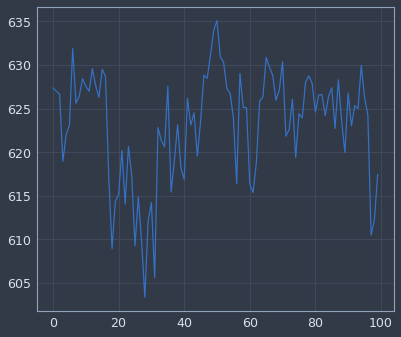

In [11]:
env_kwargs['n_envs'] = 256
episode_reward_sums += a3c_alg.train(n_episodes=70, **rl_alg_kwargs, **env_kwargs)
plt.plot(episode_reward_sums)
plt.show();

In [15]:
temp_model = a3c_alg.model_constructor()
temp_model.load_state_dict(a3c_alg.checkpoints[6])
temp_model.to(device=DEVICE)
temp_model.eval();

def model_wrapped(states):
    return temp_model.sample_action(states.unsqueeze(0)).squeeze(0)
    #return a3c_alg.model.sample_action(states.unsqueeze(0)).squeeze(0)

In [17]:
#(a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)).argmax() - len(initial_opponent_pool)
est_opp_skill = a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)
ranking = np.argsort(-est_opp_skill)
idx = 0
print(f'Opponent {ranking[idx]}, ranked {idx+1}, has an estimated win % of {est_opp_skill[ranking[idx]]:.2f}.')
print(f'Checkpoint #{ranking[idx] - len(a3c_alg.initial_opponent_pool)}')
#np.argsort(-est_opp_skill)
est_opp_skill

Opponent 9, ranked 1, has an estimated win % of 0.74.
Checkpoint #6


array([0.67284261, 0.53693121, 0.63117072, 0.48258331, 0.56685992,
       0.5884612 , 0.17225206, 0.19567818, 0.44356386, 0.73713847,
       0.45085928, 0.52311438, 0.5255525 , 0.5       ])

## Benchmark the model against a previous RL agent, and various hand-crafted algorithms

In [142]:
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', n_envs=4000, out_device=DEVICE)

100%|██████████| 1999/1999 [00:50<00:00, 39.85it/s]


new_model -vs- a3c_agent_v3
Mean scores: 640.83 - 641.77
Match score: 1930 - 55 - 2015


In [18]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

## Against itself
va.run_vectorized_vs(model_wrapped, model_wrapped, 'new_model', 'new_model', **benchmark_env_kwargs)

## Previous best models
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v0'), 'new_model', 'a3c_agent_v0', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v1'), 'new_model', 'a3c_agent_v1', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v2'), 'new_model', 'a3c_agent_v2', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', **benchmark_env_kwargs)
# TODO: Add v4-162 as opponent

## Always 0 agent
#va.run_vectorized_vs(model_wrapped, va.AlwaysFirstAgent(), 'new_model', 'always_first', **benchmark_env_kwargs)

## Random agent
#va.run_vectorized_vs(model_wrapped, va.RandomAgent(), 'new_model', 'random_agent', **benchmark_env_kwargs)

## Basic thompson sampling
va.run_vectorized_vs(model_wrapped, va.BasicThompsonSampling(OBS_NORM), 'new_model', 'basic_thompson_sampling', **benchmark_env_kwargs)

## Pull vegas slot machines
va.run_vectorized_vs(model_wrapped, va.PullVegasSlotMachines(OBS_NORM), 'new_model', 'pull_vegas_slot_machines', **benchmark_env_kwargs)

100%|██████████| 1999/1999 [00:33<00:00, 60.19it/s]


new_model -vs- new_model
Mean scores: 639.05 - 640.11
Match score: 481 - 10 - 509


100%|██████████| 1999/1999 [00:19<00:00, 100.29it/s]


new_model -vs- a3c_agent_v0
Mean scores: 645.01 - 635.11
Match score: 626 - 10 - 364


100%|██████████| 1999/1999 [00:21<00:00, 91.54it/s]


new_model -vs- a3c_agent_v1
Mean scores: 635.92 - 640.96
Match score: 407 - 8 - 585


100%|██████████| 1999/1999 [00:23<00:00, 85.91it/s]


new_model -vs- a3c_agent_v2
Mean scores: 644.86 - 636.34
Match score: 630 - 10 - 360


100%|██████████| 1999/1999 [00:23<00:00, 86.18it/s]


new_model -vs- a3c_agent_v3
Mean scores: 631.40 - 646.90
Match score: 273 - 15 - 712


100%|██████████| 1999/1999 [00:17<00:00, 113.85it/s]


new_model -vs- basic_thompson_sampling
Mean scores: 640.49 - 623.76
Match score: 707 - 18 - 275


100%|██████████| 1999/1999 [00:17<00:00, 113.74it/s]


new_model -vs- pull_vegas_slot_machines
Mean scores: 634.81 - 637.97
Match score: 453 - 18 - 529


## Benchmark the model against the checkpointed version

In [ ]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

checkpointed_model = GraphNNA3C(**graph_nn_kwargs)
checkpointed_model.to(torch.device('cuda'))
checkpointed_model.load_state_dict(model_sd_checkpoint)
checkpointed_model.eval()

def checkpointed_model_wrapped(states):
    return checkpointed_model.sample_action(states.unsqueeze(0)).squeeze(0)

va.run_vectorized_vs(model_wrapped, checkpointed_model_wrapped, 'new_model', 'checkpointed_model', **benchmark_env_kwargs)

In [ ]:
temp_sd_checkpoint = model.state_dict()

## Visualize model parameter distributions

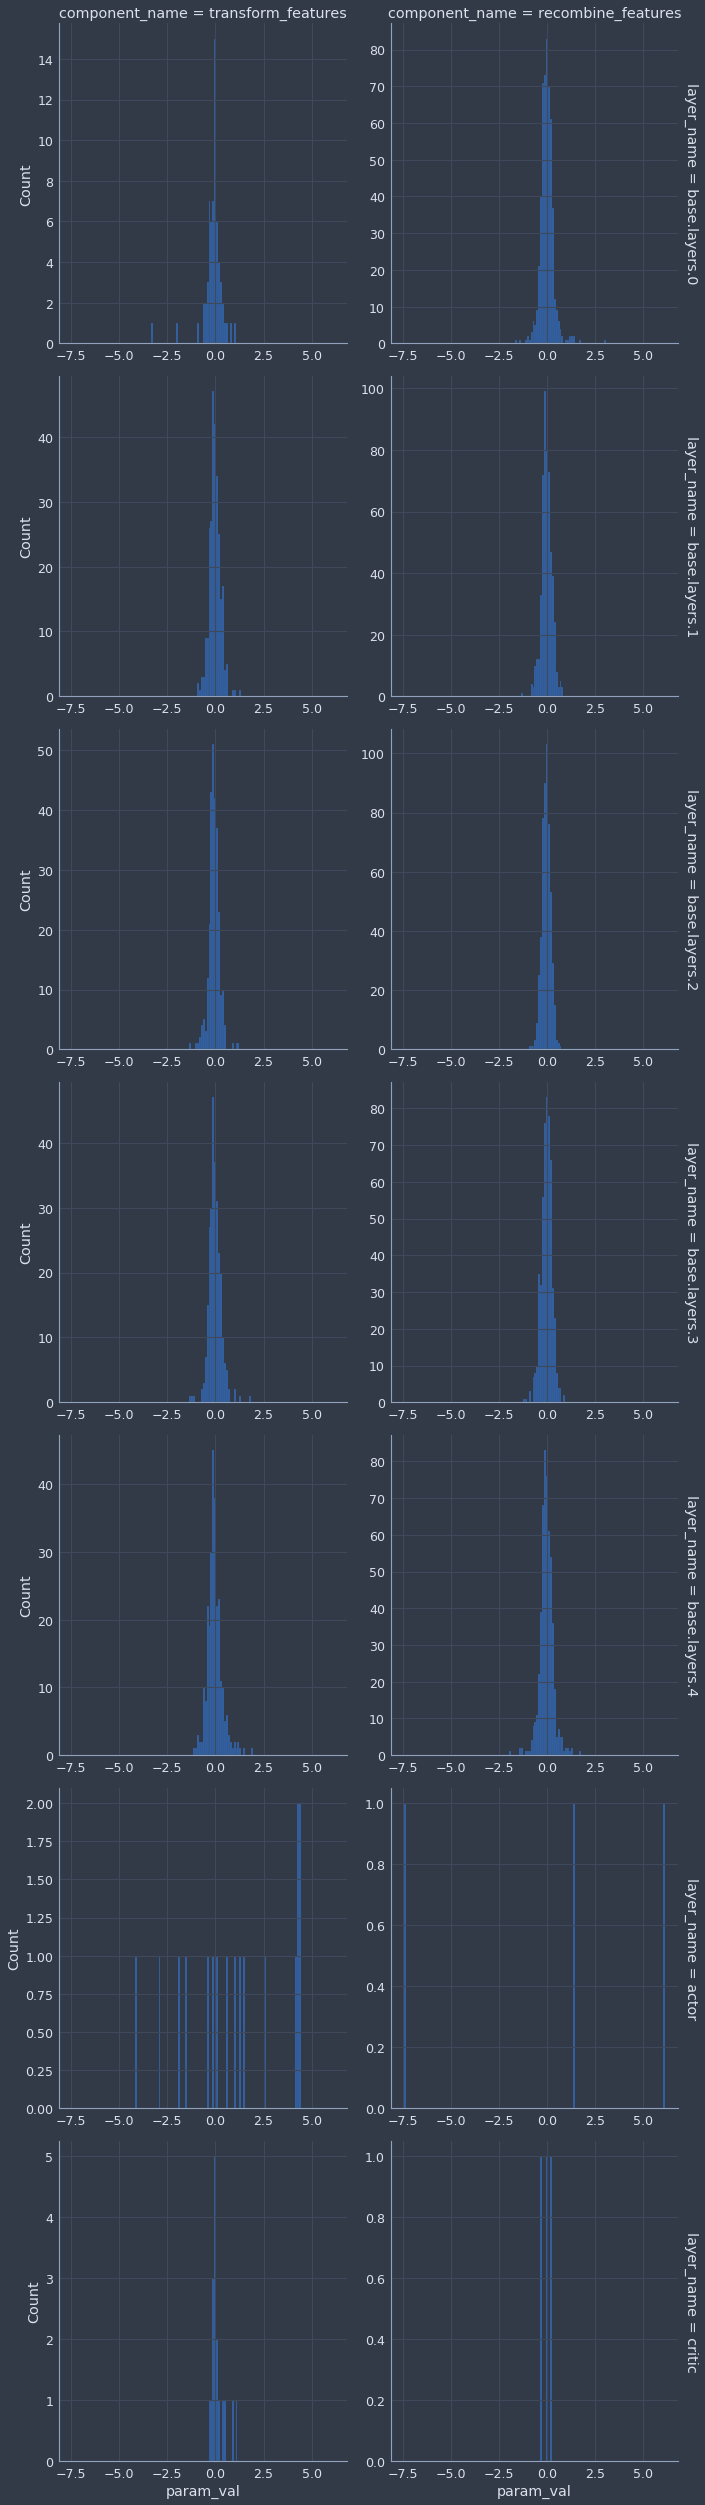

In [17]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in model.state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

In [ ]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in GraphNNA3C(**graph_nn_kwargs).state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

## Save the model state_dict as a serialized string

In [27]:
model.to('cpu')
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/ss_temp.txt', 'w') as f:
    f.write(str(serialized_string))
model.to(device=DEVICE);

## Testing and debugging

In [19]:
s.shape

torch.Size([1, 2, 100, 3])

In [18]:
from scipy.stats import spearmanr, pearsonr

test_env = KaggleMABEnvTorchVectorized(n_players=2, decay_rate=0.97)
with torch.no_grad():
    test_env.reset()
    # Take n good actions
    for i in range(500):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
    logits, values = model(s[0,0].to(device=DEVICE)[None, None, :])
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(values)
print(s[:,0].squeeze().t())
print(spearmanr(logits, test_env.thresholds.squeeze().cpu().numpy())[0],
      pearsonr(logits, test_env.thresholds.squeeze().cpu().numpy())[0])


[ -50.70728   343.18048  -360.98813  -184.58109   343.18048   343.18048
 -179.55315  -371.94223   343.18048  -101.76725  -289.71634   343.18048
  343.18033  -101.76725  -101.7673    343.1806    343.18048   -55.70023
 -423.23956   343.18048   343.18048  -144.07784  -483.9645   -132.49835
  343.18048  -284.71515  -214.44508   -36.317387  343.18033   343.1806
 -144.07787  -181.13568  -172.01115   330.54306  -392.00793   -42.726707
 -100.718575  343.18048  -232.7463   -184.58109  -182.04886   343.18048
 -209.41711  -139.44606  -169.4972    343.1806    343.18033  -309.7208
  343.18048   330.54306  -137.13019  -130.38986   343.18048   343.18048
  343.18048  -206.90314   343.18048   132.18704  -179.55313  -289.71637
 -141.76196   343.1806    343.18033  -222.74408   343.18048   343.18048
 -360.98813   343.18048   343.18048   343.18048  -174.52518  -166.98323
  343.18048   -50.707306 -164.46925   -50.707294 -130.38986  -416.65625
 -164.46925   343.1806   -209.41711  -100.9217    343.18048  -18

In [ ]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

In [ ]:
test_env = KaggleMABEnvTorchVectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=DEVICE)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

In [ ]:
# Simulated env rollouts with random policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
# Simulated env rollouts with omniscient optimal policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

In [ ]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

In [ ]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

In [ ]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

## Deprecated

In [ ]:
# Loosely based on: https://github.com/MorvanZhou/pytorch-A3C
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=DEVICE)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=DEVICE).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=DEVICE).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=DEVICE)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=DEVICE),
                    torch.stack(buffer_a).to(device=DEVICE),
                    torch.stack(buffer_v_target).to(device=DEVICE)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
        episode_reward_sums[-1] = episode_reward_sums[-1].mean()
    return episode_reward_sums

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [ ]:
class FeedForwardNN_A3C(nn.Module):
    def __init__(self, in_features, n_bandits, activation_func=nn.ReLU()):
        super().__init__()
        self.in_features = in_features
        self.activation_func = activation_func
        layer_size = 128
        self.base = nn.Sequential(
            nn.Linear(self.in_features, layer_size),
            activation_func,
            nn.Linear(layer_size, layer_size),
            activation_func,
        )
        self.actor = nn.Linear(layer_size, n_bandits)
        self.critic = nn.Linear(layer_size, 1)
        
    def forward(self, states):
        in_shape = states.shape
        base_out = self.base(states.view(-1, self.in_features))
        return self.activation_func(self.actor(base_out)).view(in_shape[:-1]), self.critic(base_out).view(in_shape[:-2])
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
        
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss